In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import proplot as pplt

import torch
import torch.nn as nn

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

current_path = !pwd
parent_path = os.path.dirname(current_path[0])
if parent_path not in sys.path: sys.path.append(parent_path)

import utils.model_handling as model_utils
import utils.dataset_generation as iso_data
import utils.histogram_analysis as hist_funcs
import utils.principal_curvature as curve_utils
import utils.plotting as plot_funcs

In [2]:
def gabor_fn(theta, sigma=2, Lambda=10, psi=np.pi/2, gamma=.8, center=(0, 0), size=(28, 28), normalize=True):
    """Returns a gabor filter.
    Args:
        theta (float): Orientation of the sinusoid (in radians).
        sigma (float): std deviation of the Gaussian.
        Lambda (float): Sinusoid wavelengh (1/frequency).
        psi (float): Phase of the sinusoid.
        gamma (float): The ratio between sigma in x-dim over sigma in y-dim (acts
            like an aspect ratio of the Gaussian).
        center (tuple of integers): The position of the filter.
        size (tuple of integers): Image height and width.
        normalize (bool): Whether to normalize the entries. This is computed by
            dividing each entry by the root sum squared of the whole image.
    Returns:
        2D Numpy array: A gabor filter.
    """
    sigma_x = sigma
    sigma_y = sigma / gamma
    xmax, ymax = size
    xmax, ymax = (xmax - 1)/2, (ymax - 1)/2
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax+1), np.arange(xmin, xmax+1))
    # shift the positon
    y -= center[0]
    x -= center[1]
    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    # Gabor equation
    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    if normalize:
        gb /= np.sqrt(np.sum(gb ** 2)) # root sum squared
        gb -= gb.mean() # make sure the sum is equal to zero
    return gb


def get_network_response_linear(img, weights):
    """Linear network, weights shape should be [img.size, num_neurons]"""
    responses = (img.reshape(-1)[None, :] @ weights).T # column vector [num_neurons, 1]
    return responses


def get_unit_response_linear(img, weights, unit_id=None):
    if unit_id is None: # weights are for an individual unit
        response = img.reshape(-1)[None, :] @ weights.reshape(-1)[:, None] 
    else: # weights are for a network, need to select the individual unit
        response = get_network_response_linear(img, weights)[unit_id]
    return response


def get_unit_response_complex(img, w1, w2):
    u1 = get_unit_response_linear(img, w1)
    u2 = get_unit_response_linear(img, w2)
    if type(img) == type(torch.Tensor()):
        response = torch.sqrt_(u1**2 + u2**2)
    else:
        response = np.sqrt(u1**2 + u2**2)
    return response


def get_lateral_weights(network_weights):
    return np.matmul(network_weights.T, network_weights) - np.eye(network_weights.shape[1])


def get_unit_response_gdn(img, network_weights, unit_id):
    network_responses = get_network_response_linear(img, network_weights)
    lateral_weights = np.square(get_lateral_weights(network_weights))
    bias = np.mean(lateral_weights)
    weighted_responses = np.matmul(lateral_weights, np.square(network_responses))
    normalization_coefficient = np.sqrt(np.square(bias) + weighted_responses)
    normalized_responses = network_responses / normalization_coefficient
    return normalized_responses[unit_id], lateral_weights


def get_unit_response_softmax(img, network_weights, unit_id):
    network_responses = get_network_response_linear(img, network_weights)
    normalized_responses = np.exp(network_responses) / np.sum(np.exp(network_responses))
    return normalized_responses[unit_id]


def get_unit_response_sparse_coding(img, network_weights, unit_id, num_steps=25, threshold=0.2, step_size=0.05):
    threshold_units = lambda x: np.where(np.greater(x, threshold), x - threshold, np.zeros_like(x))
    forward_drive = get_network_response_linear(img, network_weights)
    lateral_weights = get_lateral_weights(network_weights)
    internal_states = np.zeros((network_weights.shape[1], 1))
    for step_index in range(num_steps):
        inhibitory_input = np.matmul(lateral_weights, threshold_units(internal_states))
        du = forward_drive - inhibitory_input - internal_states
        internal_states = internal_states + step_size * du
    return threshold_units(internal_states)[unit_id]

In [3]:
experiment_params = dict()
experiment_params['x_range'] = (-2.0, 2.0)
experiment_params['y_range'] = (-2.0, 2.0)
experiment_params['num_images'] = int(40**2)
experiment_params['num_top_neurons'] = 10
experiment_params['num_comparisons_per_neuron'] = 150
experiment_params['target'] = 0.7 * (1 / experiment_params['x_range'][1]) # 70% MEI contrast
experiment_params['target_is_act'] = False
experiment_params['bounds'] = None
experiment_params['measure_between_vecs'] = False#True

experiment_params['num_gauss_fits'] = 20
experiment_params['gauss_thresh'] = 0.2
experiment_params['gauss_confidence_cutoff'] = 0.90 #This percentage of probability density will be preserved

yx_range = (experiment_params['y_range'], experiment_params['x_range'])
num_images_per_edge = int(np.sqrt(experiment_params['num_images']))

experiment_params['target_unit_ids'] = [0]
experiment_params['data_shape'] = [1, 28, 28]
experiment_params['image_scale'] = 1.0

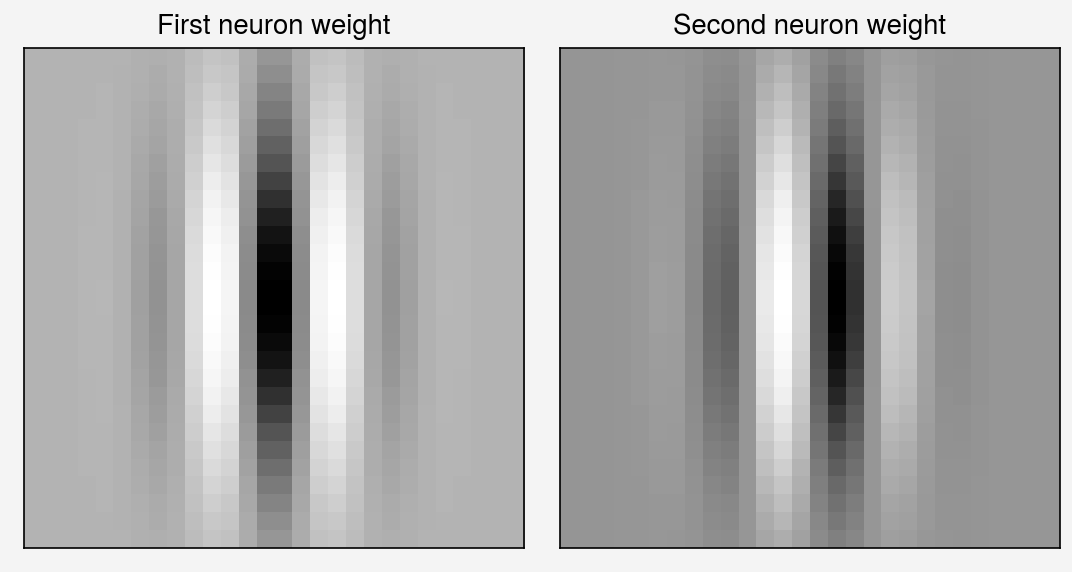

inner product between gabors = 8.326672684688674e-17


In [4]:
size = tuple(experiment_params['data_shape'][1:])
normalize = False

theta = np.pi/2; sigma = 3.5; Lambda = size[0]/4; gamma = 0.5; center = [0, 0]

psi = np.pi
gabor1 = gabor_fn(theta, sigma, Lambda, psi, gamma, center, size, normalize)
gabor1 = gabor1 / np.linalg.norm(gabor1)

psi = np.pi/2
gabor2 = gabor_fn(theta, sigma, Lambda, psi, gamma, center, size, normalize)
gabor2 = gabor2 / np.linalg.norm(gabor2)

fig, axs = pplt.subplots(nrows=1, ncols=2)
axs[0].imshow(gabor1, cmap='greys_r')
axs[0].format(title='First neuron weight', xticks=[], yticks=[])
axs[1].imshow(gabor2, cmap='greys_r')
axs[1].format(title='Second neuron weight', xticks=[], yticks=[])
pplt.show()

print(f'inner product between gabors = {np.dot(gabor1.reshape(-1)[None, :], gabor2.reshape(-1)[:, None]).item()}')

In [5]:
num_target_planes = 1
num_comp_planes = 1
plane_abscissae = [gabor1.reshape(-1)] # horizontal axes for the planes
plane_ordinates = [[gabor2.reshape(-1)]] # vertical axes for the planes

contour_dataset = iso_data.get_contour_dataset(
    plane_abscissae,
    plane_ordinates,
    yx_range=yx_range,
    num_images=experiment_params['num_images'],
    image_scale=experiment_params['image_scale'],
    data_shape=experiment_params['data_shape'],
    return_datapoints=True
)

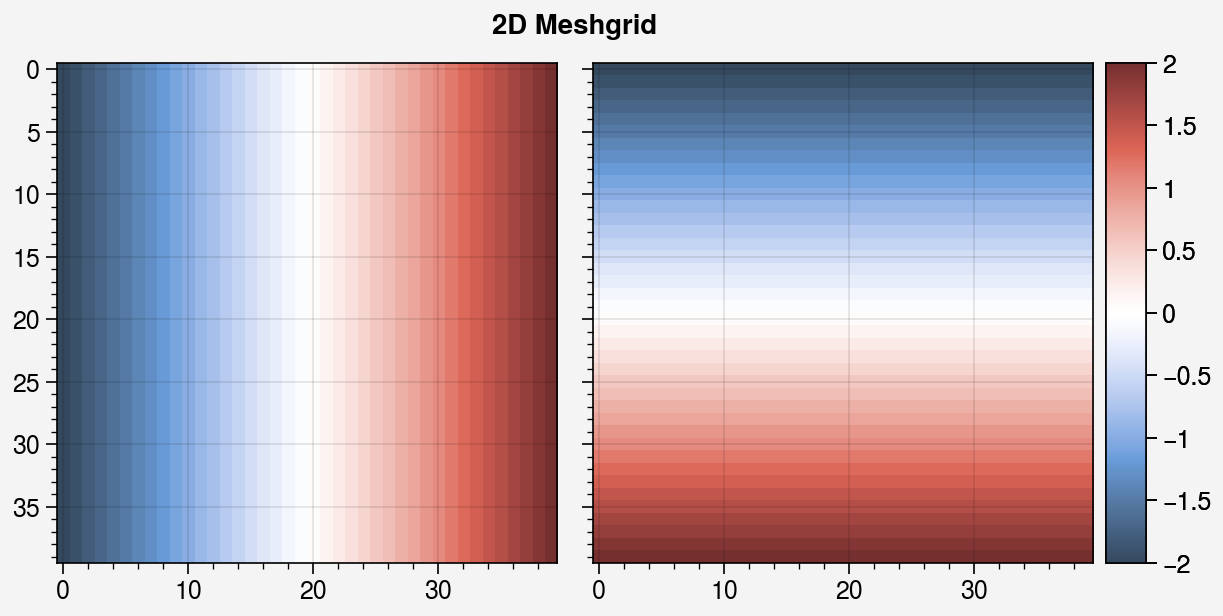

In [6]:
fig, axs = pplt.subplots(nrows=1, ncols=2)
new_shape = (num_images_per_edge, num_images_per_edge)
axs[0].imshow(contour_dataset['proj_datapoints'][:,0].reshape(new_shape))
mappable = axs[1].imshow(contour_dataset['proj_datapoints'][:,1].reshape(new_shape))
axs[1].colorbar(mappable)
axs.format(suptitle='2D Meshgrid')
pplt.show()

In [7]:
datapoints = contour_dataset.pop('all_datapoints')[0][0]
out_shape = (1, 1, 1, num_images_per_edge, num_images_per_edge)
response_images = np.zeros(out_shape)
act = np.zeros(experiment_params['num_images'])
for data_idx in range(datapoints.shape[0]):
    act[data_idx] = get_unit_response_complex(datapoints[data_idx, ...], gabor1, gabor2)
response_images[0, 0, 0, ...] = act.reshape(num_images_per_edge, num_images_per_edge)

num_y, num_x = response_images.shape[-2:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
yx_scale_factors, yx_lims = hist_funcs.get_scale_factors(yx_pts, num_y, num_x, experiment_params['bounds'])
preproc_resp_images = hist_funcs.crop_and_mask_activity_map(response_images, yx_lims, contour_dataset, mask=experiment_params['measure_between_vecs'])[0, ...]
iso_curvatures, iso_fits, iso_contours = hist_funcs.iso_response_curvature_poly_fits(
    preproc_resp_images,
    target=experiment_params['target'],
    target_is_act=experiment_params['target_is_act'],
    yx_scale=yx_scale_factors
)

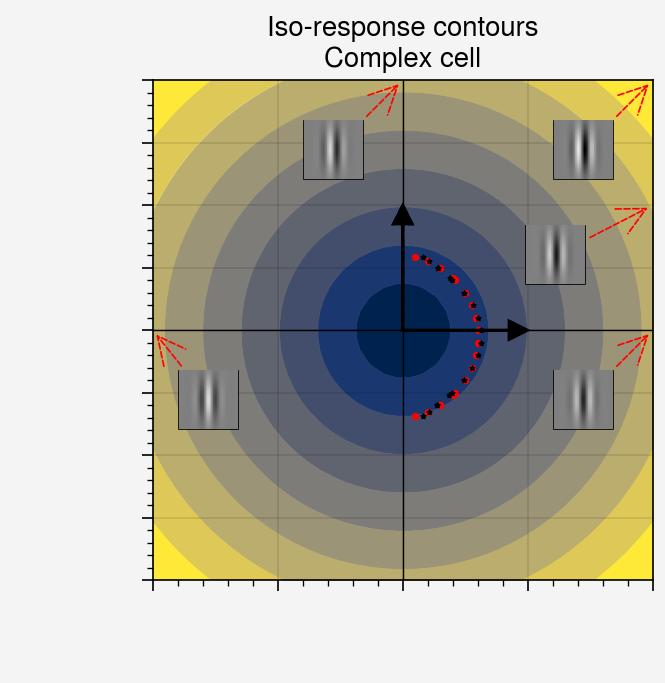

In [9]:
target_plane_id = 0
comp_plane_id = 0

num_y, num_x = response_images.shape[3:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())

fig, ax = pplt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)

proj_vects = (
    contour_dataset['proj_target_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_comparison_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_orth_vect'][target_plane_id][comp_plane_id],
)
contsf = plot_funcs.plot_contours(
    ax,
    activity=response_images[0, target_plane_id, comp_plane_id, ...],
    yx_pts=yx_pts,
    yx_range=yx_range,
    proj_vects=proj_vects,
    num_levels=10,
    contours=iso_contours[target_plane_id][comp_plane_id],
    fits=iso_fits[target_plane_id][comp_plane_id],
    title=''#f'C={np.round(curvatures[target_plane_id][comp_plane_id], 2)}'
)
proj_matrix = contour_dataset['proj_matrix'][target_plane_id][comp_plane_id]
stim_images = iso_data.inject_data(
    proj_matrix,
    contour_dataset['proj_datapoints'],
    experiment_params['image_scale'],
    experiment_params['data_shape']
)
stim_images = stim_images.reshape(num_images_per_edge, num_images_per_edge, *stim_images.shape[1:])

images_vmin = datapoints.min()
images_vmax = datapoints.max()
overlay_images = []

axis_y_pos = 0
axis_x_pos = 2
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 2
axis_x_pos = 2
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 1
axis_x_pos = 2
offset = [-35, -18]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 2
axis_x_pos = 0
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 0
axis_x_pos = -2
offset = [20, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

ax.format(
    title='Iso-response contours\nComplex cell',
    ylim=experiment_params['y_range'],
    xlim=experiment_params['x_range'],
    xticklabels=[],
    yticklabels=[]
)

pplt.show()

In [10]:
noise_sample = np.random.randn(gabor1.size)
plane_ordinates = [[noise_sample / np.linalg.norm(noise_sample)]] 
contour_dataset = iso_data.get_contour_dataset(
    plane_abscissae,
    plane_ordinates,
    yx_range=yx_range,
    num_images=experiment_params['num_images'],
    image_scale=experiment_params['image_scale'],
    data_shape=experiment_params['data_shape'],
    return_datapoints=True
)

datapoints = contour_dataset.pop('all_datapoints')[0][0]
out_shape = (1, 1, 1, num_images_per_edge, num_images_per_edge)
response_images = np.zeros(out_shape)
act = np.zeros(experiment_params['num_images'])
for data_idx in range(datapoints.shape[0]):
    act[data_idx] = get_unit_response_linear(datapoints[data_idx, ...], gabor1)
response_images[0, 0, 0, ...] = act.reshape(num_images_per_edge, num_images_per_edge)

num_y, num_x = response_images.shape[-2:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
yx_scale_factors, yx_lims = hist_funcs.get_scale_factors(yx_pts, num_y, num_x, experiment_params['bounds'])
preproc_resp_images = hist_funcs.crop_and_mask_activity_map(response_images, yx_lims, contour_dataset, mask=experiment_params['measure_between_vecs'])[0, ...]
iso_curvatures, iso_fits, iso_contours = hist_funcs.iso_response_curvature_poly_fits(
    preproc_resp_images,
    target=experiment_params['target'],
    target_is_act=experiment_params['target_is_act'],
    yx_scale=yx_scale_factors
)

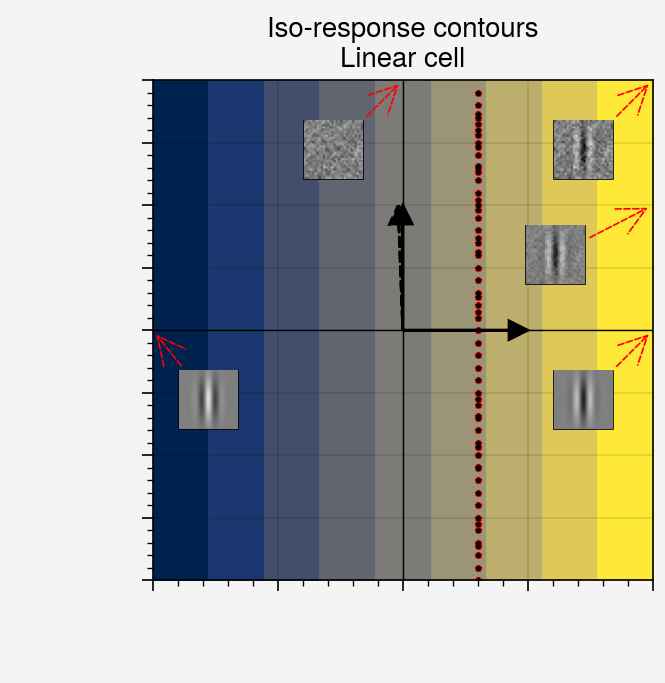

In [11]:
target_plane_id = 0
comp_plane_id = 0

fig, ax = pplt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)

proj_vects = (
    contour_dataset['proj_target_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_comparison_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_orth_vect'][target_plane_id][comp_plane_id],
)

contsf = plot_funcs.plot_contours(
    ax,
    activity=response_images[0, target_plane_id, comp_plane_id, ...],
    yx_pts=yx_pts,
    yx_range=yx_range,
    proj_vects=proj_vects,
    num_levels=10,
    contours=iso_contours[target_plane_id][comp_plane_id],
    fits=iso_fits[target_plane_id][comp_plane_id],
    title=''#f'C={np.round(curvatures[target_plane_id][comp_plane_id], 2)}'
)
proj_matrix = contour_dataset['proj_matrix'][target_plane_id][comp_plane_id]
stim_images = iso_data.inject_data(
    proj_matrix,
    contour_dataset['proj_datapoints'],
    experiment_params['image_scale'],
    experiment_params['data_shape']
)
stim_images = stim_images.reshape(num_images_per_edge, num_images_per_edge, *stim_images.shape[1:])

images_vmin = datapoints.min()
images_vmax = datapoints.max()
overlay_images = []

axis_y_pos = 0
axis_x_pos = 2
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 2
axis_x_pos = 2
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 1
axis_x_pos = 2
offset = [-35, -18]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 2
axis_x_pos = 0
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 0
axis_x_pos = -2
offset = [20, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

ax.format(
    title='Iso-response contours\nLinear cell',
    ylim=experiment_params['y_range'],
    xlim=experiment_params['x_range'],
    xticklabels=[],
    yticklabels=[]
)

pplt.show()

In [13]:
n_orientation = 5
n_freq = 5
n_center = 10
n_stds = 2

orientations = np.linspace(0, np.pi, n_orientation)
frequencies = np.linspace(size[0]/4, size[0]/2, n_freq) 
locations_y = np.linspace(-size[0]/5, size[0]/5, int(np.sqrt(n_center)))
locations_x = np.linspace(-size[1]/5, size[1]/5, int(np.sqrt(n_center)))
locations = [[loc_y, loc_x] for loc_y in locations_y for loc_x in locations_x]
gauss_stds = np.linspace(3.5, 4.0, n_stds)
gauss_aspects = [0.5]
phases = [np.pi]
size = tuple(experiment_params['data_shape'][1:])
normalize = False

gabor_bank = []
for freq in frequencies:
    for orientation in orientations:
        for center in locations:
            for aspect in gauss_aspects:
                for std in gauss_stds:
                    for phase in phases:
                        gabor = gabor_fn(orientation, std, freq, phase, aspect, center, size, normalize)
                        gabor = gabor / np.linalg.norm(gabor)
                        gabor_bank.append(gabor.reshape(-1))
gabor_bank = np.stack(gabor_bank, axis=1) # [num_inputs, num_outputs]

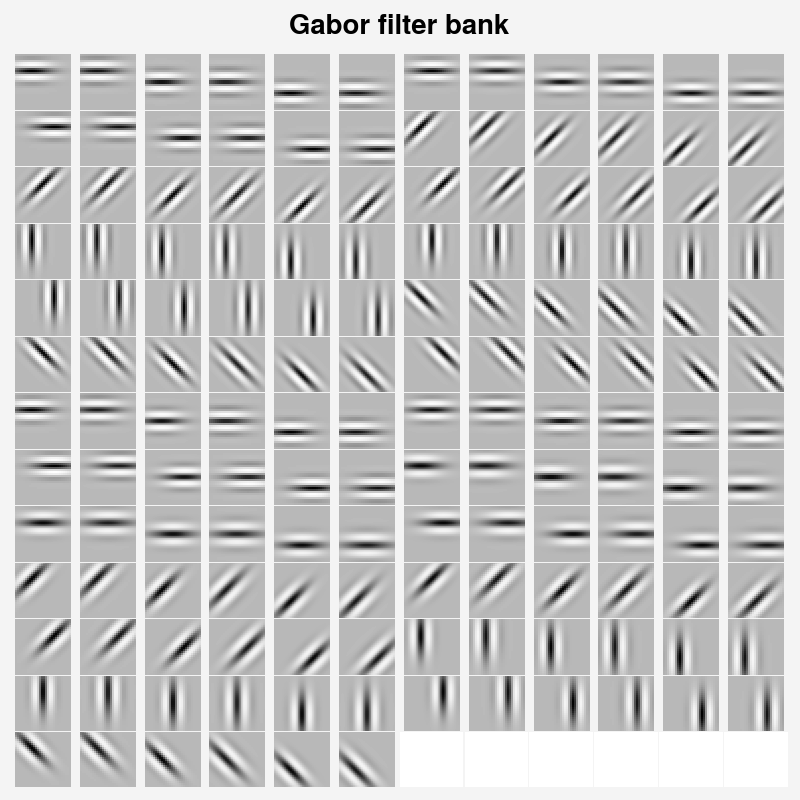

In [14]:
vmin = np.min(gabor_bank)
vmax = np.max(gabor_bank)
num_plots = np.minimum(150, gabor_bank.shape[0])
num_plots_y = int(np.ceil(np.sqrt(num_plots)))
num_plots_x = int(np.floor(np.sqrt(num_plots)))
fig, axs = pplt.subplots(nrows=num_plots_y, ncols=num_plots_x, space=0.05, width=4, height=4)
filter_total = 0
for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
    if filter_total < num_plots:
        ax = plot_funcs.clear_axis(axs[plot_id])
        ax.imshow(np.squeeze(gabor_bank[:, filter_total].reshape(size)), vmin=vmin, vmax=vmax, cmap="greys_r")
        filter_total += 1
    else:
        ax = plot_funcs.clear_axis(axs[plot_id])
axs.format(suptitle = 'Gabor filter bank')
pplt.show()

In [15]:
num_target_planes = 1
num_comp_planes = 1
unit_id, comp_id = (0, 2)
plane_abscissae = [gabor_bank[:, unit_id]]
plane_ordinates = [[gabor_bank[:, comp_id]]]

contour_dataset = iso_data.get_contour_dataset(
    plane_abscissae,
    plane_ordinates,
    yx_range=yx_range,
    num_images=experiment_params['num_images'],
    image_scale=experiment_params['image_scale'],
    data_shape=experiment_params['data_shape'],
    return_datapoints=True
)
datapoints = contour_dataset.pop('all_datapoints')[0][0]
out_shape = (1, 1, 1, num_images_per_edge, num_images_per_edge)
response_images = np.zeros(out_shape)
act = np.zeros(experiment_params['num_images'])
for data_idx in range(datapoints.shape[0]):
    act[data_idx], gamma = get_unit_response_gdn(datapoints[data_idx, ...], gabor_bank, unit_id)
response_images[0, 0, 0, ...] = act.reshape(num_images_per_edge, num_images_per_edge)

num_y, num_x = response_images.shape[-2:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
yx_scale_factors, yx_lims = hist_funcs.get_scale_factors(yx_pts, num_y, num_x, experiment_params['bounds'])
preproc_resp_images = hist_funcs.crop_and_mask_activity_map(response_images, yx_lims, contour_dataset, mask=experiment_params['measure_between_vecs'])[0, ...]
iso_curvatures, iso_fits, iso_contours = hist_funcs.iso_response_curvature_poly_fits(
    preproc_resp_images,
    target=experiment_params['target'],
    target_is_act=experiment_params['target_is_act'],
    yx_scale=yx_scale_factors
)

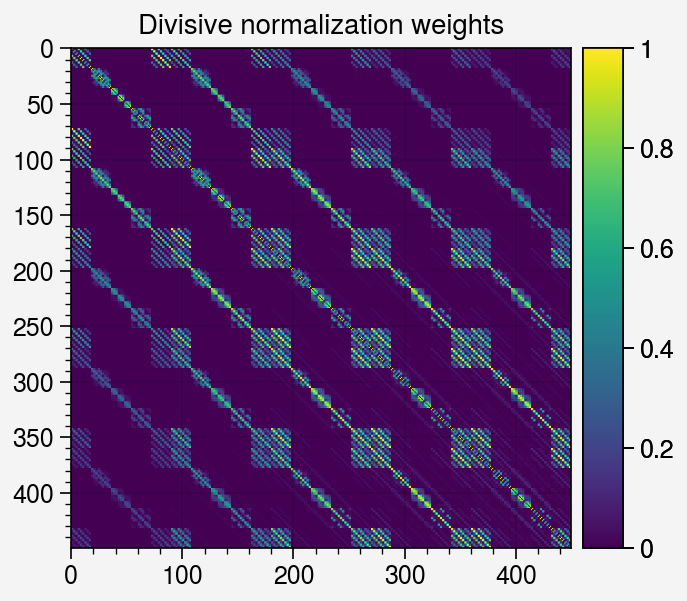

In [16]:
fig, ax = pplt.subplots(nrows=1, ncols=1)
mappable = ax.imshow(gamma, cmap='viridis')
ax.colorbar(mappable)
ax.format(title='Divisive normalization weights')
pplt.show()

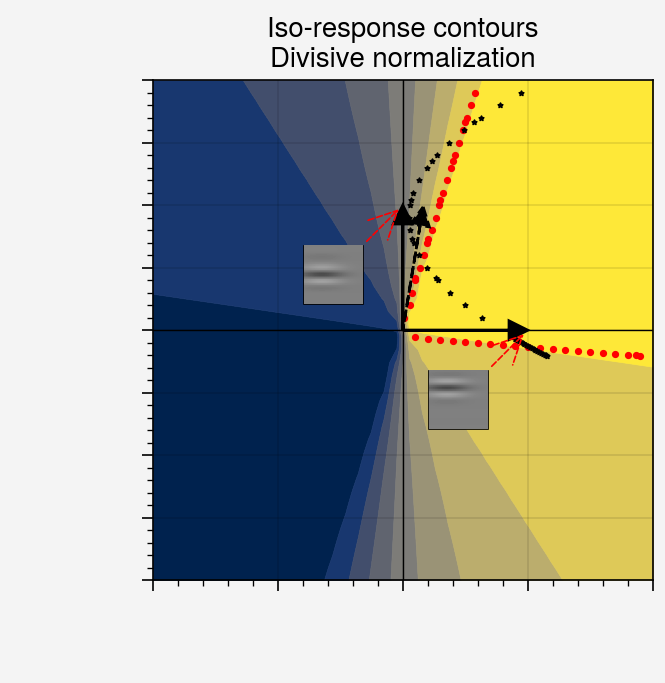

In [17]:
target_plane_id = 0
comp_plane_id = 0

num_y, num_x = response_images.shape[3:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())

fig, ax = pplt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)

proj_vects = (
    contour_dataset['proj_target_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_comparison_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_orth_vect'][target_plane_id][comp_plane_id],
)

contsf = plot_funcs.plot_contours(
    ax,
    activity=response_images[0, target_plane_id, comp_plane_id, ...],
    yx_pts=yx_pts,
    yx_range=yx_range,
    proj_vects=proj_vects,
    num_levels=10,
    contours=iso_contours[target_plane_id][comp_plane_id],
    fits=iso_fits[target_plane_id][comp_plane_id],
    title=''#f'C={np.round(curvatures[target_plane_id][comp_plane_id], 2)}'
)
proj_matrix = contour_dataset['proj_matrix'][target_plane_id][comp_plane_id]
stim_images = iso_data.inject_data(
    proj_matrix,
    contour_dataset['proj_datapoints'],
    experiment_params['image_scale'],
    experiment_params['data_shape']
)
stim_images = stim_images.reshape(num_images_per_edge, num_images_per_edge, *stim_images.shape[1:])

overlay_images = []

images_vmin = datapoints.min()
images_vmax = datapoints.max()

axis_y_pos = 0
axis_x_pos = 1
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 1
axis_x_pos = 0
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

ax.format(
    title='Iso-response contours\nDivisive normalization',
    ylim=experiment_params['y_range'],
    xlim=experiment_params['x_range'],
    xticklabels=[],
    yticklabels=[]
)

pplt.show()

In [18]:
num_target_planes = 1
num_comp_planes = 1
unit_id, comp_id = (0, 2)
plane_abscissae = [gabor_bank[:, unit_id]]
plane_ordinates = [[gabor_bank[:, comp_id]]]

contour_dataset = iso_data.get_contour_dataset(
    plane_abscissae,
    plane_ordinates,
    yx_range=yx_range,
    num_images=experiment_params['num_images'],
    image_scale=experiment_params['image_scale'],
    data_shape=experiment_params['data_shape'],
    return_datapoints=True
)
datapoints = contour_dataset.pop('all_datapoints')[0][0]
out_shape = (1, 1, 1, num_images_per_edge, num_images_per_edge)
response_images = np.zeros(out_shape)
act = np.zeros(experiment_params['num_images'])
for data_idx in range(datapoints.shape[0]):
    act[data_idx] = get_unit_response_softmax(datapoints[data_idx, ...], gabor_bank, unit_id)
response_images[0, 0, 0, ...] = act.reshape(num_images_per_edge, num_images_per_edge)

num_y, num_x = response_images.shape[-2:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
yx_scale_factors, yx_lims = hist_funcs.get_scale_factors(yx_pts, num_y, num_x, experiment_params['bounds'])
preproc_resp_images = hist_funcs.crop_and_mask_activity_map(response_images, yx_lims, contour_dataset, mask=experiment_params['measure_between_vecs'])[0, ...]
iso_curvatures, iso_fits, iso_contours = hist_funcs.iso_response_curvature_poly_fits(
    preproc_resp_images,
    target=experiment_params['target'],
    target_is_act=experiment_params['target_is_act'],
    yx_scale=yx_scale_factors
)

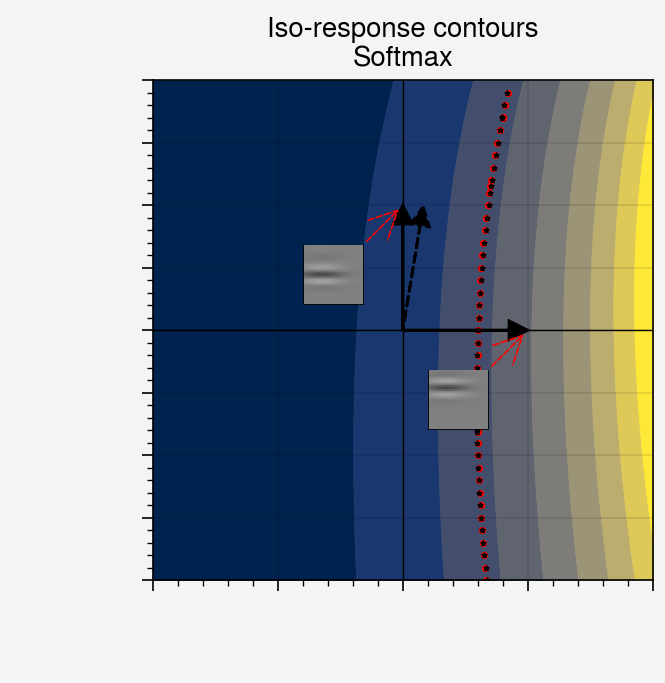

In [20]:
target_plane_id = 0
comp_plane_id = 0
num_y, num_x = response_images.shape[3:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
fig, ax = pplt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
proj_vects = (
    contour_dataset['proj_target_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_comparison_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_orth_vect'][target_plane_id][comp_plane_id],
)
contsf = plot_funcs.plot_contours(
    ax,
    activity=response_images[0, target_plane_id, comp_plane_id, ...],
    yx_pts=yx_pts,
    yx_range=yx_range,
    proj_vects=proj_vects,
    num_levels=10,
    contours=iso_contours[target_plane_id][comp_plane_id],
    fits=iso_fits[target_plane_id][comp_plane_id],
    title=''#f'C={np.round(curvatures[target_plane_id][comp_plane_id], 2)}'
)
proj_matrix = contour_dataset['proj_matrix'][target_plane_id][comp_plane_id]
stim_images = iso_data.inject_data(
    proj_matrix,
    contour_dataset['proj_datapoints'],
    experiment_params['image_scale'],
    experiment_params['data_shape']
)
stim_images = stim_images.reshape(num_images_per_edge, num_images_per_edge, *stim_images.shape[1:])
overlay_images = []
images_vmin = datapoints.min()
images_vmax = datapoints.max()

axis_y_pos = 0
axis_x_pos = 1
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 1
axis_x_pos = 0
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

ax.format(
    title='Iso-response contours\nSoftmax',
    ylim=experiment_params['y_range'],
    xlim=experiment_params['x_range'],
    xticklabels=[],
    yticklabels=[]
)
pplt.show()


In [21]:
num_target_planes = 1
num_comp_planes = 1
unit_id, comp_id = (0, 2)
plane_abscissae = [gabor_bank[:, unit_id]]
plane_ordinates = [[gabor_bank[:, comp_id]]]

contour_dataset = iso_data.get_contour_dataset(
    plane_abscissae,
    plane_ordinates,
    yx_range=yx_range,
    num_images=experiment_params['num_images'],
    image_scale=experiment_params['image_scale'],
    data_shape=experiment_params['data_shape'],
    return_datapoints=True
)
datapoints = contour_dataset.pop('all_datapoints')[0][0]
out_shape = (1, 1, 1, num_images_per_edge, num_images_per_edge)
response_images = np.zeros(out_shape)
act = np.zeros(experiment_params['num_images'])
for data_idx in range(datapoints.shape[0]):
    act[data_idx] = get_unit_response_sparse_coding(datapoints[data_idx, ...], gabor_bank, unit_id)
response_images[0, 0, 0, ...] = act.reshape(num_images_per_edge, num_images_per_edge)

num_y, num_x = response_images.shape[-2:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
yx_scale_factors, yx_lims = hist_funcs.get_scale_factors(yx_pts, num_y, num_x, experiment_params['bounds'])
preproc_resp_images = hist_funcs.crop_and_mask_activity_map(response_images, yx_lims, contour_dataset, mask=experiment_params['measure_between_vecs'])[0, ...]
iso_curvatures, iso_fits, iso_contours = hist_funcs.iso_response_curvature_poly_fits(
    preproc_resp_images,
    target=experiment_params['target'],
    target_is_act=experiment_params['target_is_act'],
    yx_scale=yx_scale_factors
)

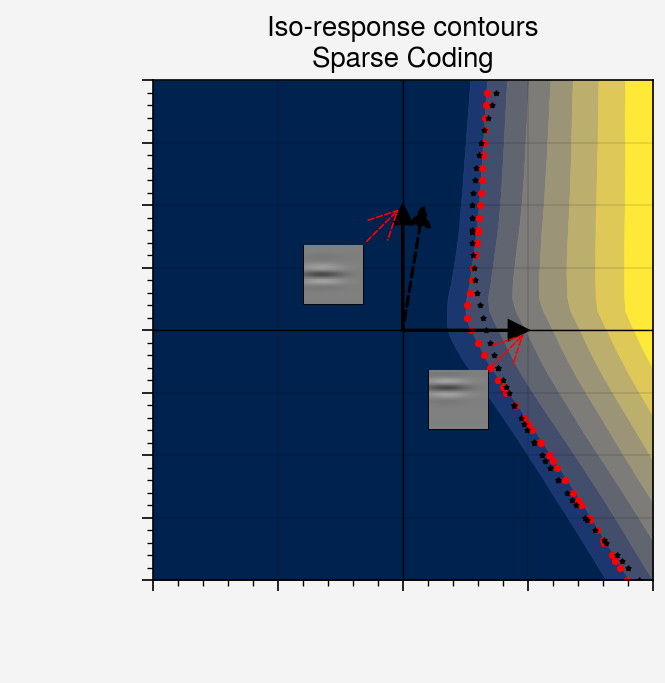

In [22]:
target_plane_id = 0
comp_plane_id = 0
num_y, num_x = response_images.shape[3:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
fig, ax = pplt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
proj_vects = (
    contour_dataset['proj_target_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_comparison_vect'][target_plane_id][comp_plane_id],
    contour_dataset['proj_orth_vect'][target_plane_id][comp_plane_id],
)
contsf = plot_funcs.plot_contours(
    ax,
    activity=response_images[0, target_plane_id, comp_plane_id, ...],
    yx_pts=yx_pts,
    yx_range=yx_range,
    proj_vects=proj_vects,
    num_levels=10,
    contours=iso_contours[target_plane_id][comp_plane_id],
    fits=iso_fits[target_plane_id][comp_plane_id],
    title=''#f'C={np.round(curvatures[target_plane_id][comp_plane_id], 2)}'
)
proj_matrix = contour_dataset['proj_matrix'][target_plane_id][comp_plane_id]
stim_images = iso_data.inject_data(
    proj_matrix,
    contour_dataset['proj_datapoints'],
    experiment_params['image_scale'],
    experiment_params['data_shape']
)
stim_images = stim_images.reshape(num_images_per_edge, num_images_per_edge, *stim_images.shape[1:])
overlay_images = []
images_vmin = datapoints.min()
images_vmax = datapoints.max()

axis_y_pos = 0
axis_x_pos = 1
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

axis_y_pos = 1
axis_x_pos = 0
offset = [-25, -25]
img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
overlay_images.append(img)

ax.format(
    title='Iso-response contours\nSparse Coding',
    ylim=experiment_params['y_range'],
    xlim=experiment_params['x_range'],
    xticklabels=[],
    yticklabels=[]
)
pplt.show()

In [23]:
def torchify(img):
    return torch.from_numpy(img).type(torch.FloatTensor).to(DEVICE)

class pytorch_complex(nn.Module):
    def __init__(self, w1, w2):
        super(pytorch_complex, self).__init__()
        self.w1 = w1
        self.w2 = w2

    def forward(self, data):
        z_vals = get_unit_response_complex(data, self.w1, self.w2)
        return z_vals.reshape((data.shape[0], 1)) #1 neuron

hess_params = dict()
hess_params['hessian_num_pts'] = 1.5e4
hess_params['hessian_lr'] = 1e-4
hess_params['hessian_random_walk'] = False
hess_params['return_points'] = False
hess_params['hessian_dist'] = 1.0

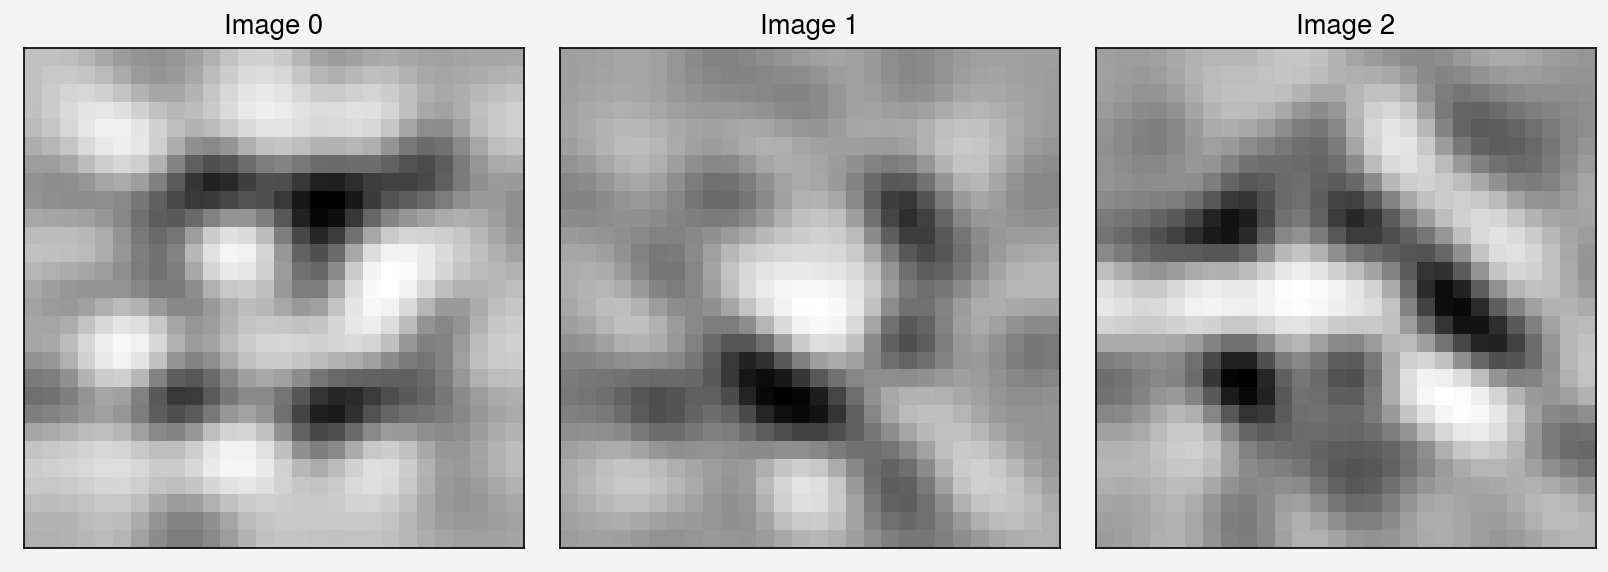

In [24]:
# generate a handful of images by combining gabors
num_images = 5
num_pixels, num_neurons = gabor_bank.shape
images = np.matmul(np.random.laplace(loc=0, scale=1, size=[num_images, num_neurons]), gabor_bank.T)

fig, axs = pplt.subplots(nrows=1, ncols=3)
axs[0].imshow(images[0, ...].reshape(28,28), cmap='greys')
axs[0].format(title='Image 0')
axs[1].imshow(images[1, ...].reshape(28,28), cmap='greys')
axs[1].format(title='Image 1')
axs[2].imshow(images[2, ...].reshape(28,28), cmap='greys')
axs[2].format(title='Image 2')
axs.format(xticks=[], yticks=[])
pplt.show()

In [25]:
# setup a pytorch complex cell neuron
model = pytorch_complex(torchify(gabor1), torchify(gabor2))
model.to(DEVICE)

def sr1_func(x):
    act, grad = model_utils.unit_activation_and_gradient(model, x, 0)
    return act, grad

def autodiff_func(x):
    act = model_utils.unit_activation(model, x, 0)
    return act

# measure the neuron's principal curvature for each image
shape_operators = np.zeros((num_images, num_pixels, num_pixels))
principal_curvatures = np.zeros((num_images, num_pixels))
principal_directions = np.zeros((num_images, num_pixels, num_pixels))
for image_idx in range(images.shape[0]):
    torch_image = torchify(images[image_idx, ...][None,...])
    torch_image.requires_grad = True
    hessian = torch.autograd.functional.hessian(autodiff_func, torch_image)
    hessian = hessian.reshape((num_pixels, num_pixels))
    #hessian = curve_utils.sr1_hessian(
    #    sr1_func, torch_image,
    #    distance=hess_params['hessian_dist'],
    #    n_points=hess_params['hessian_num_pts'],
    #    random_walk=hess_params['hessian_random_walk'],
    #    learning_rate=hess_params['hessian_lr'],
    #    return_points=False,
    #    progress=False)
    gradient = sr1_func(torch_image)[1].reshape(-1)
    curvature = curve_utils.local_response_curvature_graph(gradient, hessian)
    shape_operators[image_idx, ...] = curvature[0].detach().cpu().numpy()
    principal_curvatures[image_idx, :] = curvature[1].detach().cpu().numpy()
    principal_directions[image_idx, ...] = curvature[2].detach().cpu().numpy()

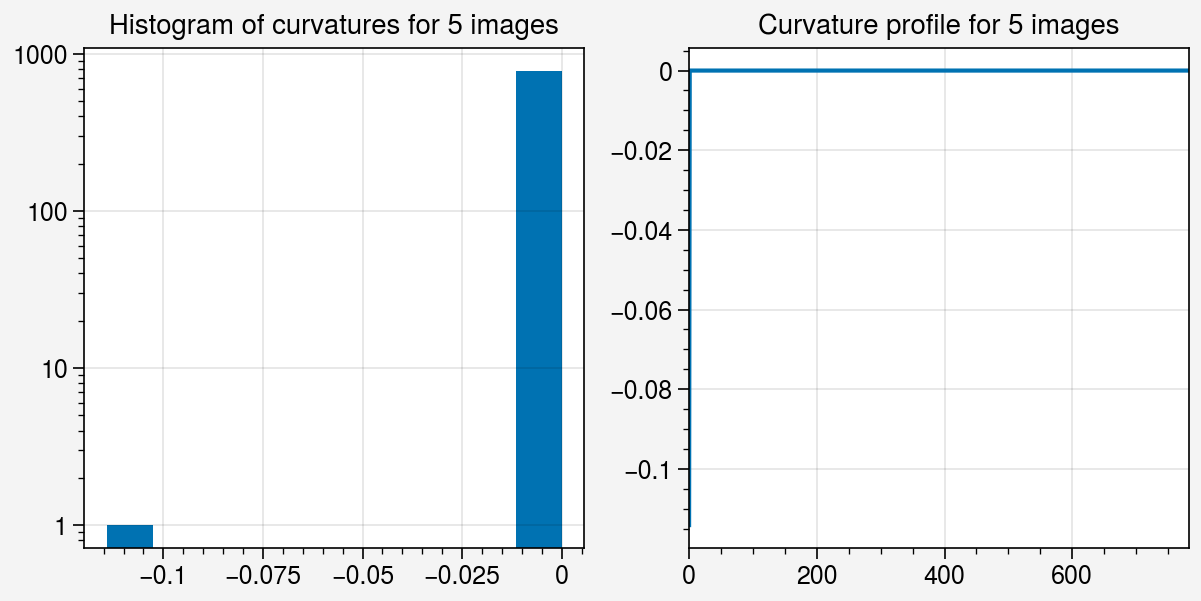

In [26]:
fig, ax = pplt.subplots(nrows=1, ncols=2, sharey=False)
ax[0].hist(principal_curvatures.mean(axis=0), log=True)
ax[0].format(title=f'Histogram of curvatures for {num_images} images')
ax[1].plot(np.sort(principal_curvatures.mean(axis=0)))
ax[1].format(title=f'Curvature profile for {num_images} images')
pplt.show()

In [29]:
image_index = np.random.randint(low=0, high=num_images)

max_curvature_plane = np.argmax(principal_curvatures[image_index, :])
max_curvature_direction = principal_directions[image_index, :, max_curvature_plane]

min_curvature_plane = np.argmin(principal_curvatures[image_index, :])
min_curvature_direction = principal_directions[image_index, :, min_curvature_plane]

origin = images[image_index, ...][None, ...]

torch_origin = torchify(origin)
torch_origin.requires_grad = True
gradient = sr1_func(torch_origin)[1].reshape(-1)

num_target_planes = 1
num_comp_planes = 1
plane_abscissae = [gradient.detach().cpu().numpy()] # horizontal axes for the planes
plane_ordinates = [[min_curvature_direction, max_curvature_direction]] # vertical axes for the planes

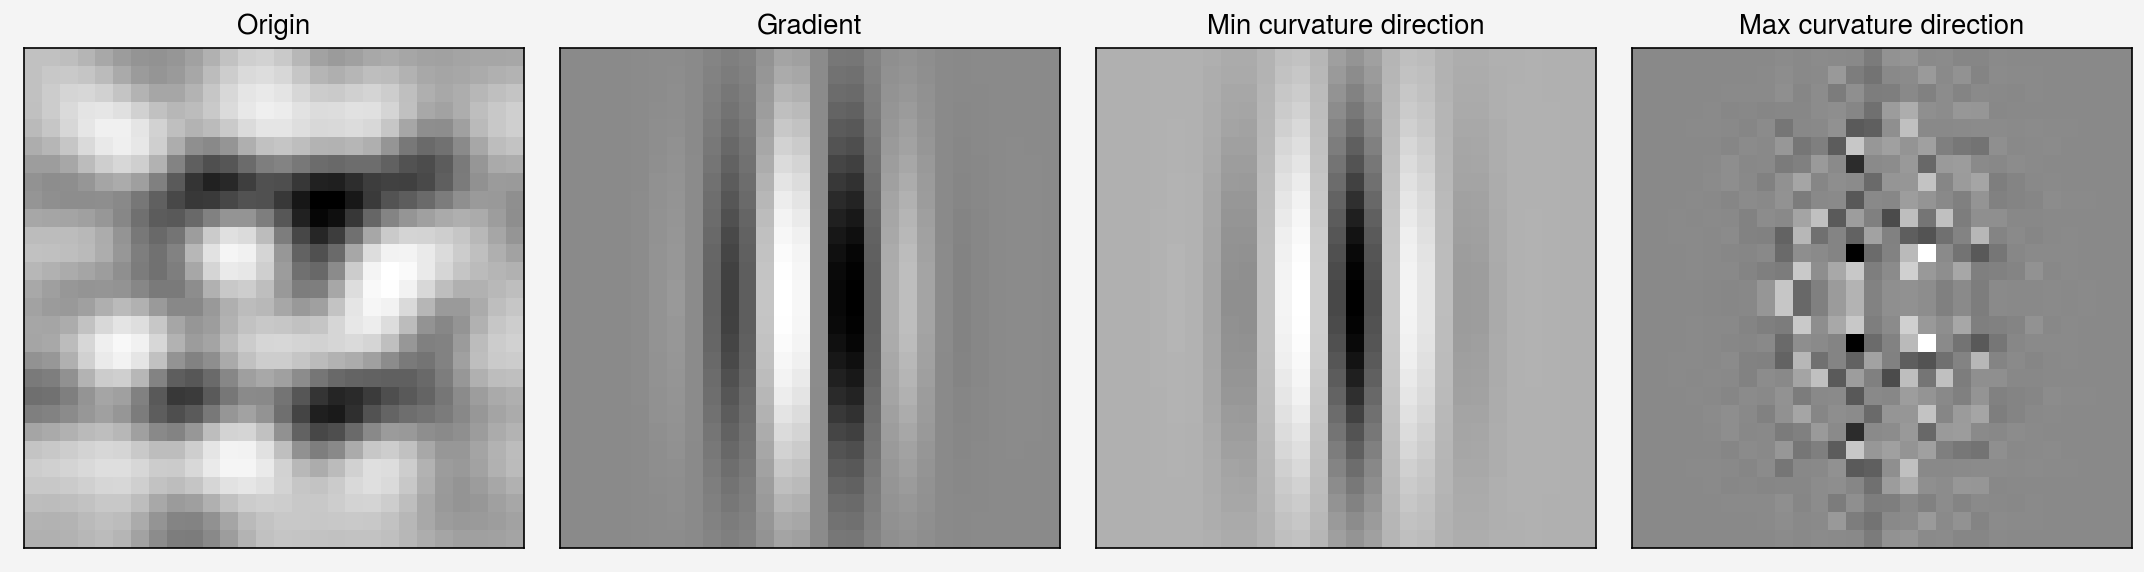

gradient and min curvature inner product = 5.317790180425774e-09
gradient and max curvature inner product = -0.28047561691179435


In [30]:
fig, axs = pplt.subplots(nrows=1, ncols=4)
axs[0].imshow(origin.reshape(28,28), cmap='greys')
axs[0].format(title='Origin')
axs[1].imshow(plane_abscissae[0].reshape(28,28), cmap='greys')
axs[1].format(title='Gradient')
axs[2].imshow(plane_ordinates[0][0].reshape(28,28), cmap='greys')
axs[2].format(title='Min curvature direction')
axs[3].imshow(plane_ordinates[0][1].reshape(28,28), cmap='greys')
axs[3].format(title='Max curvature direction')
axs.format(xticks=[], yticks=[])
pplt.show()

print(f'gradient and min curvature inner product = {np.dot(plane_abscissae[0], plane_ordinates[0][0])}')
print(f'gradient and max curvature inner product = {np.dot(plane_abscissae[0], plane_ordinates[0][1])}')

In [31]:
contour_dataset = iso_data.get_contour_dataset(
    plane_abscissae,
    plane_ordinates,
    yx_range=yx_range,
    num_images=experiment_params['num_images'],
    image_scale=experiment_params['image_scale'],
    data_shape=experiment_params['data_shape'],
    return_datapoints=True
)
out_shape = (len(plane_abscissae), len(plane_ordinates[0]), num_images_per_edge, num_images_per_edge)
response_images = np.zeros(out_shape)

all_datapoints = contour_dataset.pop('all_datapoints')
target_plane_id = 0
for comp_plane_id in range(out_shape[1]):
    plane_datapoints = all_datapoints[target_plane_id][comp_plane_id]
    plane_datapoints += origin.reshape(1, int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels)))
    act = np.zeros(experiment_params['num_images'])
    for data_idx in range(plane_datapoints.shape[0]):
        act[data_idx] = model(torchify(plane_datapoints[data_idx, ...][None,...]))
    response_images[0, comp_plane_id, ...] = act.reshape(num_images_per_edge, num_images_per_edge)

num_y, num_x = response_images.shape[-2:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
yx_scale_factors, yx_lims = hist_funcs.get_scale_factors(yx_pts, num_y, num_x, experiment_params['bounds'])
iso_curvatures, iso_fits, iso_contours = hist_funcs.iso_response_curvature_poly_fits(
    response_images,
    target=experiment_params['target'],
    target_is_act=experiment_params['target_is_act'],
    yx_scale=yx_scale_factors
)

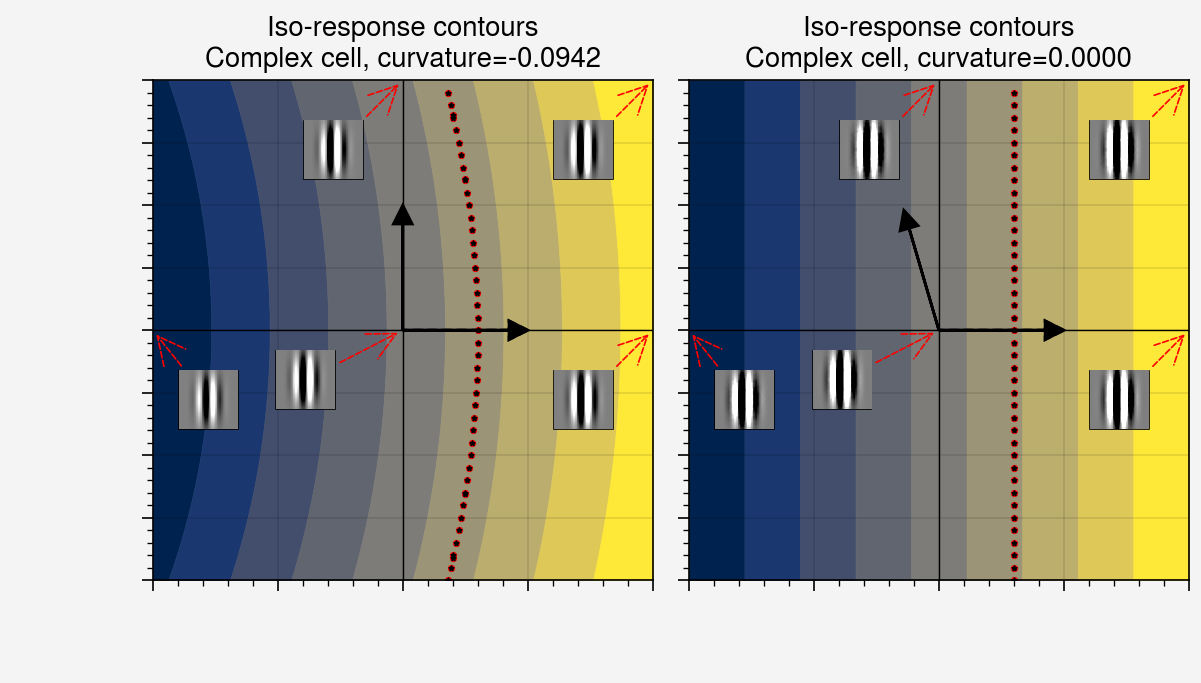

In [32]:
num_y, num_x = response_images.shape[2:]
yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())

fig, axs = pplt.subplots(nrows=1, ncols=2, sharey=False, sharex=False)

target_plane_idx = 0
for comp_plane_idx, principal_curvature_idx in enumerate([min_curvature_plane, max_curvature_plane]):
    ax = axs[comp_plane_idx]
    proj_matrix = contour_dataset['proj_matrix'][target_plane_idx][comp_plane_idx]
    contour_dataset['proj_datapoints'] += iso_data.project_data(proj_matrix, origin.reshape(1, -1))

    proj_vects = (
        contour_dataset['proj_target_vect'][target_plane_idx][comp_plane_idx],
        contour_dataset['proj_target_vect'][target_plane_idx][comp_plane_idx],
        contour_dataset['proj_comparison_vect'][target_plane_idx][comp_plane_idx],
        contour_dataset['proj_orth_vect'][target_plane_idx][comp_plane_idx],
    )
    contsf = plot_funcs.plot_contours(
        ax,
        activity=response_images[target_plane_idx, comp_plane_idx, ...],
        yx_pts=yx_pts,
        yx_range=yx_range,
        proj_vects=proj_vects,
        num_levels=10,
        contours=iso_contours[target_plane_idx][comp_plane_idx],
        fits=iso_fits[target_plane_idx][comp_plane_idx],
        title=f'Iso-response contours\nComplex cell, curvature={principal_curvatures[image_index, principal_curvature_idx]:.4f}'
    )
    stim_images = iso_data.inject_data(
        proj_matrix,
        contour_dataset['proj_datapoints'],
        experiment_params['image_scale'],
        experiment_params['data_shape']
    )
    stim_images = stim_images.reshape(num_images_per_edge, num_images_per_edge, *stim_images.shape[1:])

    images_vmin = datapoints.min()
    images_vmax = datapoints.max()
    overlay_images = []

    axis_y_pos = 0
    axis_x_pos = 0
    offset = [-35, -18]
    img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
    overlay_images.append(img)

    axis_y_pos = 0
    axis_x_pos = 2
    offset = [-25, -25]
    img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
    overlay_images.append(img)

    axis_y_pos = 2
    axis_x_pos = 2
    offset = [-25, -25]
    img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
    overlay_images.append(img)

    axis_y_pos = 2
    axis_x_pos = 0
    offset = [-25, -25]
    img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
    overlay_images.append(img)

    axis_y_pos = 0
    axis_x_pos = -2
    offset = [20, -25]
    img = plot_funcs.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, yx_range, offset, None, images_vmin, images_vmax)
    overlay_images.append(img)

    ax.format(
        ylim=experiment_params['y_range'],
        xlim=experiment_params['x_range'],
        xticklabels=[],
        yticklabels=[]
    )

pplt.show()